# DSCI 100 Final Project -
## Can the amount of hours played and age of individuals influence a player's likelihood of subscribing to a game-related newsletter about Minecraft?

In [18]:
library(tidyverse)
library(repr)
library(tidymodels)

In [19]:
url <- "https://drive.google.com/uc?export=download&id=1kBbW3nLa_kBrNruxi2itBmCwvUT29w8b" 
players_df <- read_csv(url)
head(players_df)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Introduction:
The increasing popularity of video games has led researchers to explore player behaviour, engagement, and demographics to optimize gaming experiences. A research team in Computer Science at the University of British Columbia (UBC), led by Frank Wood, analyzed player interactions within a Minecraft server to understand gaming trends better. The data consists of 196 observations (rows) and 7 variables (columns), including player experience, subscription status, encrypted email, total hours played, name, gender, and age. The dataset has potential issues that may impact the accuracy and reliability of the analysis. The overall dataset shows a significantly larger proportion of subscribed individuals than non-subscribers, resulting in a class imbalance. The variable “Age” also has two missing values that should be removed due to incomplete demographic data. Additionally, the “played_hours” variable has a wide distribution of values consisting of outliers. Most values range from 0 to 50 hours, but some individuals have up to 200+ hours. Larger values could skew the data and lead to an inaccurate analysis. Given these characteristics, the project aims to answer the question: Can the number of hours played and the age of individuals influence a player's likelihood of subscribing to a game-related newsletter on Minecraft? This question helps address the broader question by focusing on specific player characteristics as potential predictors and examining how engagement and demographics might influence subscription tendencies. 


## Methods & Results:




To gauge an initial understanding of the data, we must perform standard summary calculations relevant to exploratory analysis. The players_df dataset was summarized to produce the maximum, minimum, and average values of the Age and played_hours variables. 

In [20]:
#summary of data set values that are relevant for exploratory analysis 
players_values <- players_df |>
  summarize(
    max_played_hours = max(played_hours),
    max_age = max(Age, na.rm = TRUE),
    min_played_hours = min(played_hours),
    min_age = min(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours),
    mean_age = mean(Age, na.rm = TRUE))

players_values


max_played_hours,max_age,min_played_hours,min_age,mean_played_hours,mean_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223.1,50,0,8,5.845918,20.52062


From this information, we can see that the maximum played hours variable is around 220 hours; however, the average is around 6 hours. Therefore, we can conclude that there are some outliers in this variable. To account for these observations and prevent skewed data, we should only consider observations that include playing hours under 150 hours. 

First, we need to load the data, which can be found on GitHub, and tidy the data by turning the column “subscribe” into a factor variable from logical. The “Age” dataset also consits of missing data,so we must account for those observations in the dataset. 

In [21]:
#data wrangling to tidy the dataset
players_data_new <- players_df|>
rename(hashed_email = hashedEmail, age = Age) |>
filter(played_hours < 150.0, age != "NA") |>
select(played_hours, age,subscribe) |>
arrange(desc(played_hours))
head(players_data_new)

#mutate the response variable into factor data type using as_factor
players_mutate<-players_data_new|>
mutate(subscribe=as_factor(subscribe))

head(players_mutate)

played_hours,age,subscribe
<dbl>,<dbl>,<lgl>
56.1,23,TRUE
53.9,17,TRUE
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
56.1,23,TRUE
53.9,17,TRUE
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE


To further tidy our data, we renamed the columns so that the format is continuous across all variables (i.e., lowercase). Furthermore, the outlying data in the “played_hours” column was filtered to include playing hours less than 150 to prevent skewed results. Our question concerns the numerical values “age” and “played_hours,” so these columns were selected. The played_hours column was arranged in descending order for tidiness. 

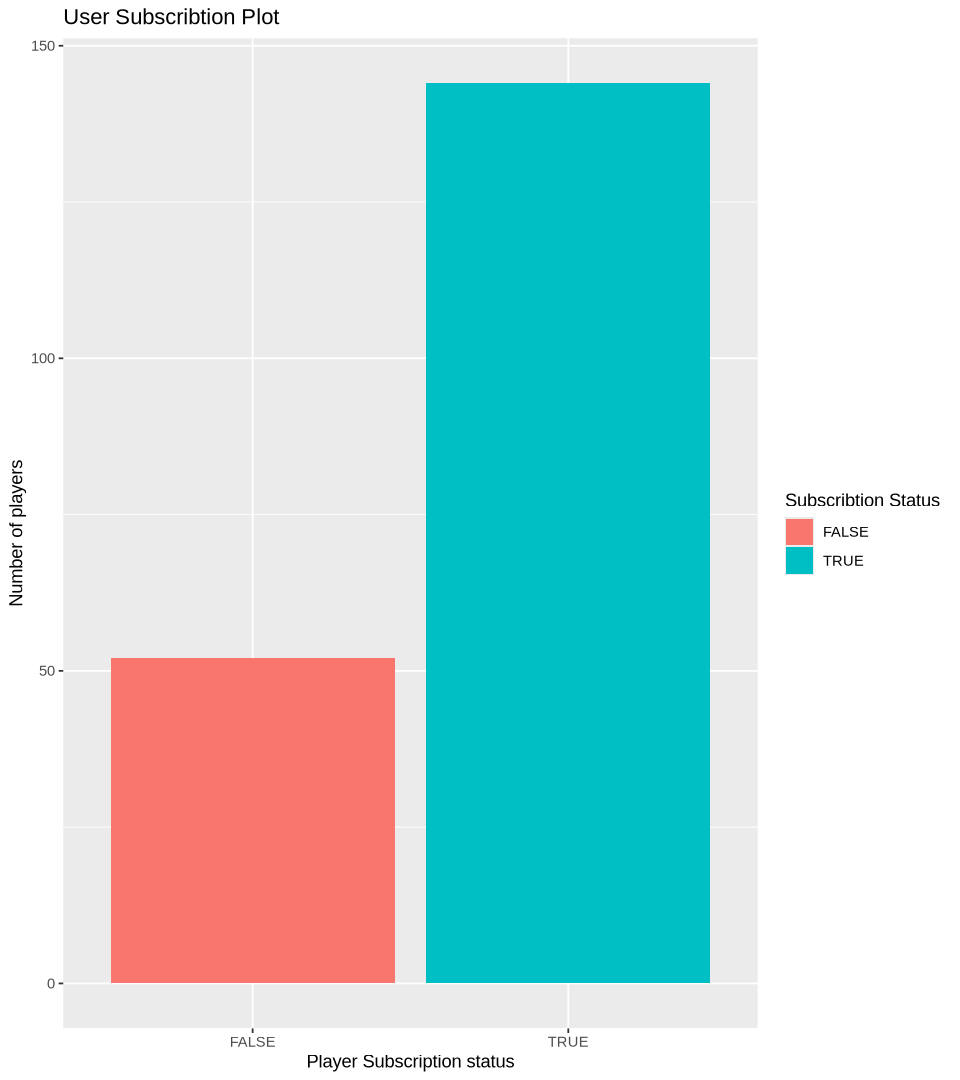

In [22]:
class_inbalance_plot <- players_df |>
                        group_by (subscribe) |>
                        summarize(count = n()) |>
                        ggplot(aes(x = subscribe, y = count, fill = subscribe)) + 
                        geom_bar(stat = "identity") + 
                        xlab("Player Subscription status") +
                        ylab("Number of players") +
                        labs(fill = "Subscribtion Status") +
                        ggtitle("User Subscribtion Plot")

class_inbalance_plot

We want to look into the original dataset to see if any imbalances would influence our classifier. A bar plot was used to create this plot to compare the number of subscribers to non-subscribers for an initial analysis. From the plot, the left bar, which represents the number of non-subscribers, is significantly lower than the right bar (number of subscribers), suggesting that there is an imbalance of the subscribe variable in the dataset as the majority of individuals are already subscribed to the newsletter.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


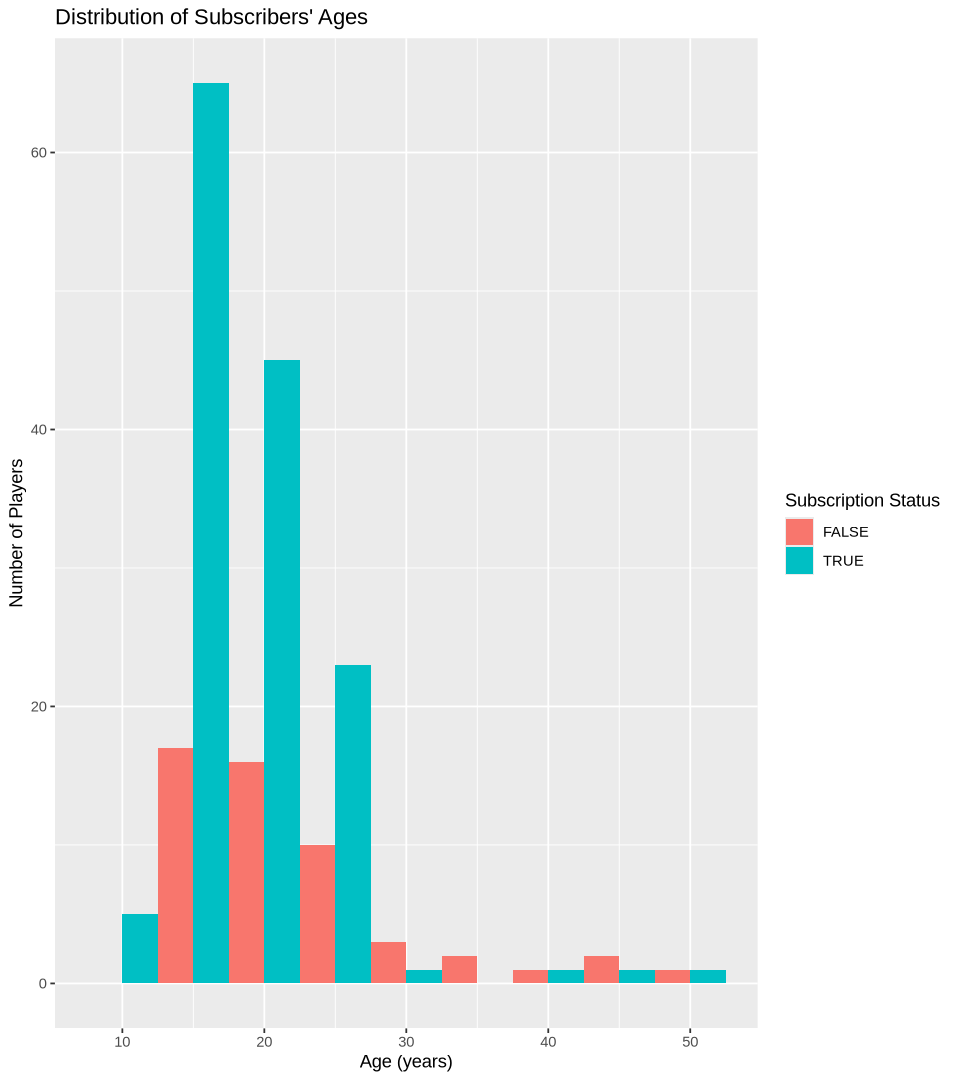

In [23]:
#Histogram illustrating players age and subscription status
age_plot<-players_df|>
ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 5, position = "dodge") +
  labs(x = "Age (years)", y = "Number of Players", title = "Distribution of Subscribers' Ages",fill = "Subscription Status")
age_plot

The histogram above was created to determine if there was a potential relationship between age and subscription status among individuals in the dataset. Histograms are used to show the distribution of a numerical variable, therefore it the most efficient plot for visualizing age as its a numerical variable in the players' dataset. The plot illustrates that younger individuals, particularly those between the ages of 15 and 23, tend to subscribe to the newsletter more often than older individuals (age 30 and above). This suggests a possible trend where younger players are more engaged or responsive to game-related content. However, these results could be due to the imbalance in the ratio of subscribers to non-subscribers, which may influence the distribution and lead to the overrepresentation of specific age groups among subscribers.

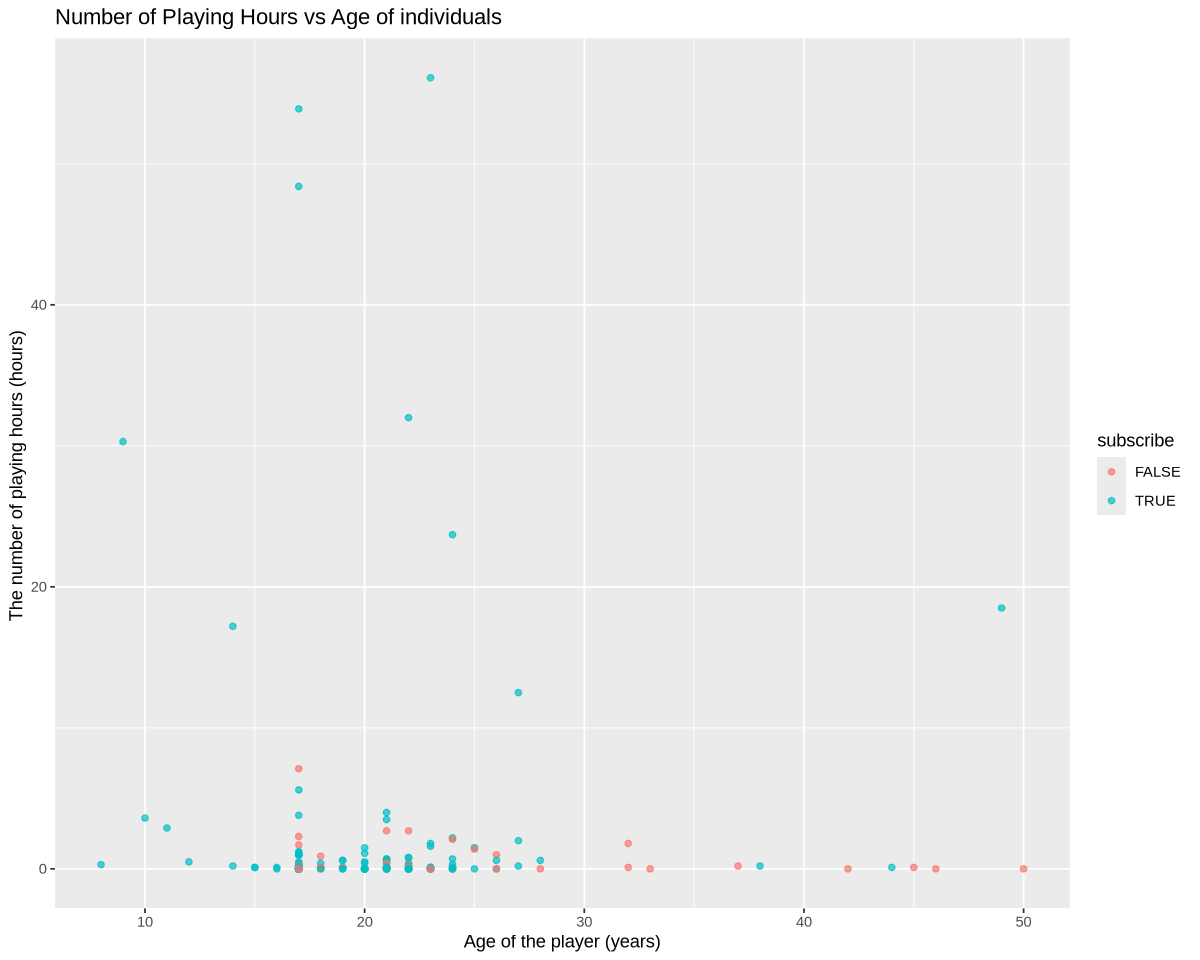

In [24]:
#visualization to determine if there is a relationship between subscirption status in individuals based on their age and hours played
options(repr.plot.width = 10, repr.plot.height = 8)
hours_to_age_plot <- players_mutate |>
   ggplot(aes(x = age, y = played_hours, color = subscribe)) + 
       geom_point(alpha = 0.7) + # Deals with the transparency of the points, set it to an appropiate value
        xlab("Age of the player (years)") +
        ylab("The number of playing hours (hours) ") +
       ggtitle("Number of Playing Hours vs Age of individuals")

hours_to_age_plot

The scatter plot above was created to explore whether there is a relationship between players’ age and the number of hours they spent playing Minecraft. A scatter plot was selected for this visualization as age and played hours are quantitative variables that can help identify data patterns. However, based on the visualization, the results are inconclusive. While the players' ages ranged from approximately 5 to 50 years, most data points are clustered near the bottom of the graph, indicating that most individuals played for only a few hours regardless of age. A few individuals with higher playtime appear towards the top of the graph, but there was no clear linear or non-linear trend between the two variables. Although colour was used to differentiate between subscribers and non-subscribers, the high concentration of overlapping data points, especially those with low playing time hours like 1.2, 1.3, or 1.6 hours, makes it difficult to detect meaningful patterns visually. Due to the lack of a visible relationship in the scatter plot, we applied the K-Nearest Neighbors (KNN) classification to investigate whether age and playtime together can predict subscription status. KNN is a non-parametric, instance-based learning algorithm that works well when there's no assumption of a linear relationship between variables. Instead of modelling an explicit relationship, KNN relies on the proximity of data points in feature space to classify new observations. KNN will aid in determining if individuals with similar ages and playing hours tend to fall into the same subscription group, thus uncovering potential patterns that are not visually obvious in the plot.

In [25]:
set.seed(3456)

players_df_split <- initial_split(players_mutate, prop = 0.75, strata = subscribe)  
players_df_train <- training(players_df_split)
players_df_test <- testing(players_df_split)

head(players_df_train)
head(players_df_test)


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
7.1,17,FALSE
2.7,22,FALSE
2.7,21,FALSE
2.1,24,FALSE
1.8,32,FALSE
1.7,17,FALSE


played_hours,age,subscribe
<dbl>,<dbl>,<fct>
48.4,17,TRUE
32.0,22,TRUE
30.3,9,TRUE
23.7,24,TRUE
18.5,49,TRUE
5.6,17,TRUE


In [26]:
#making a recpie and scaling the data
players_recipe <- recipe(subscribe ~ played_hours + age, data = players_df_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors()) 

players_recipe_scaled <- players_recipe |>
prep() |>
bake(players_df_train)
head(players_recipe_scaled)

played_hours,age,subscribe
<dbl>,<dbl>,<fct>
0.83971134,-0.62528194,FALSE
0.18545065,0.17752127,FALSE
0.18545065,0.01696063,FALSE
0.09623329,0.49864256,FALSE
0.05162460,1.78312770,FALSE
0.03675504,-0.62528194,FALSE


With our tidied data, we can now determine what K value we should use in the classification. To do this, we used set.seed(3456) so the results remain consistent each time the code is run, and then we split the data into training and testing sets by 75/25. Then we scaled and centered the players_df_train data as it was being used in our KNN model. The data was scaled because we can see from our initial standard summary calculations that the age variable ranges from 8 to 50, while the hours played variable ranges from 0 to 150. This difference is staggering  can produce skewed results if not scaled and centred, leading to inaccurate predictions. Therefore, the data must be split and scaled to ensure only the training data is manipulated and no single attribute will dominate the distance calculation. 

In [27]:
# Set the seed. 
set.seed(3456) 

options(repr.plot.height = 9, repr.plot.width = 8)

### Cross-Validation to select k value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

players_vfold <- vfold_cv(players_df_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(2:14))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5005017,5,0.021958309,Preprocessor1_Model01
3,accuracy,binary,0.5411056,5,0.025022485,Preprocessor1_Model02
4,accuracy,binary,0.5480022,5,0.026651505,Preprocessor1_Model03
5,accuracy,binary,0.5835067,5,0.021817311,Preprocessor1_Model04
6,accuracy,binary,0.5906495,5,0.021997260,Preprocessor1_Model05
7,accuracy,binary,0.5983215,5,0.009755722,Preprocessor1_Model06
8,accuracy,binary,0.6049717,5,0.019955014,Preprocessor1_Model07
9,accuracy,binary,0.6271757,5,0.024082714,Preprocessor1_Model08
10,accuracy,binary,0.6202791,5,0.020300076,Preprocessor1_Model09


We performed a 5-fold cross-validation to tune the number of neighbors (k) in a KNN classification model. The seed of 3456 was used for reproducibilty and the model is trained and evaluated on a range of k values (2 to 14). Since the total number of observations in the dataset is 196, we chose 2-14 as our range for neighbours because this rage provides a balance bewteen overfitting and underfitting. We then used the arguments tune_grid and collect_metrics to estimate each neighbour value's accuracy and then filtered for accuracy. By making a plot, we can visualize the best K value by plotting the accuracy versus neighbours.

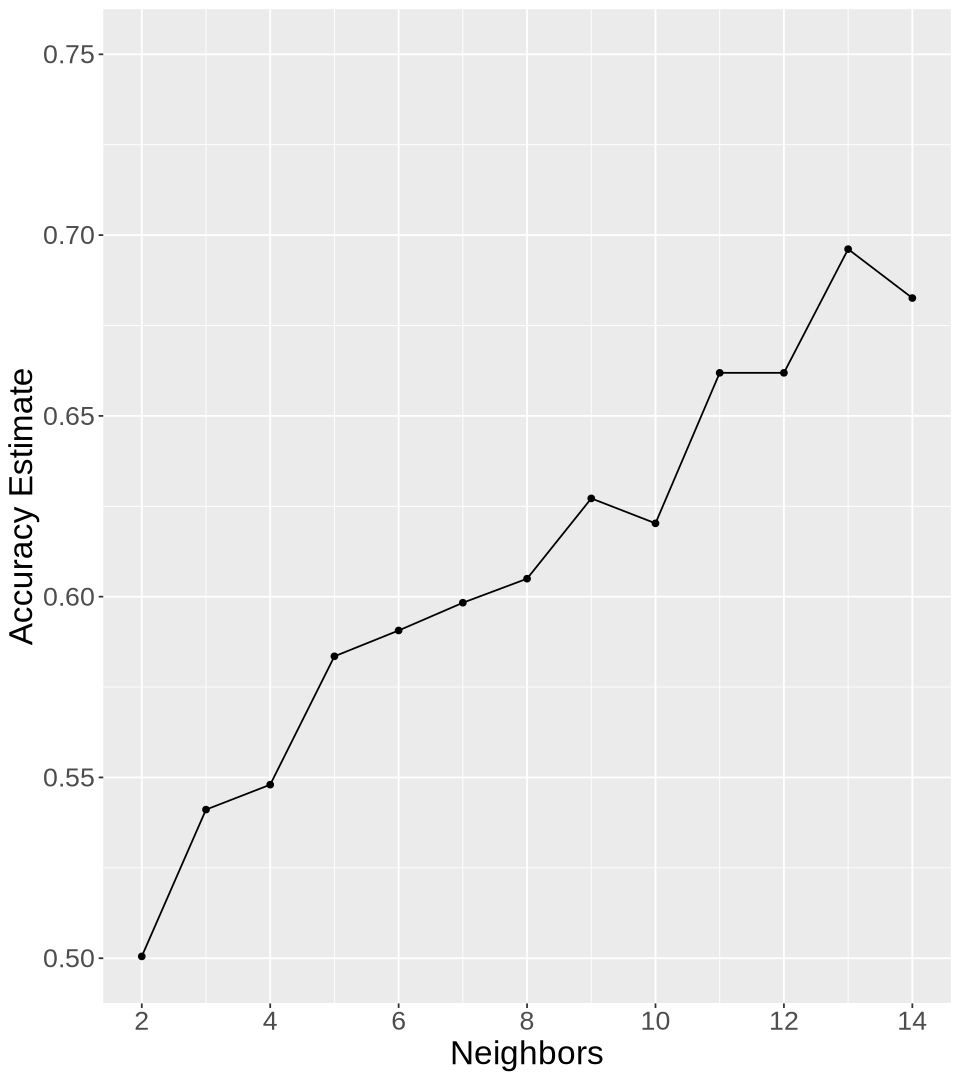

In [28]:
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20)) +
                  scale_x_continuous(breaks = seq(0, 20, 2)) +
                  scale_y_continuous(limits = c(0.5, 0.75))

cross_val_plot

This graph shows how the accuracy of our KNN classification model changes as the number of neighbours (K value) increases. The plot shows that the accuracy starts at around 50% when K=2 and gradually improves as K increases. It reaches around 70% when K=13 but slightly drops at K=14, suggesting that the accuracy is generally higher for larger K values, but if the K value is too large, it might reduce the performance of our classifier. Therefore, K=13 will be selected as the optimal value, as it balances the model's complexity and performance, resulting in the highest classification accuracy observed in the analysis.

In [29]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_df_train)
players_fit

players_predictions <- predict(players_fit, players_df_test) |>
                        bind_cols(players_df_test)

players_accuracy <- players_predictions |> 
                    metrics(truth = subscribe, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
players_accuracy
players_conf_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2816901
Best kernel: rectangular
Best k: 13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6458333
kap,binary,-0.1460674


          Truth
Prediction FALSE TRUE
     FALSE     0    4
     TRUE     13   31

The confusion matrix reveals that the KNN classification model struggles with accurately predicting subscription status due to class imbalance. Out of 48 total predictions, the model correctly identified 31 subscribers (true positives) but failed to correctly classify any non-subscribers (true negatives = 0). It also misclassified 13 non-subscribers as subscribers (false positives) and 4 as non-subscribers (false negatives). While the overall accuracy is approximately 64.6%, this is misleading, as the model overwhelmingly predicts the majority class (subscribed). 

In [30]:
players_predictions_with_labels <- players_predictions |>
      select(.pred_class) |>
      bind_cols(players_df_test |> select(subscribe, age, played_hours)) |>
      mutate(seq = 1:nrow(players_df_test)) |>
      as.data.frame()

not_matching <- players_predictions_with_labels |>
         filter(.pred_class!= subscribe) |>
         slice_sample(n = 4) 

not_matching

.pred_class,subscribe,age,played_hours,seq
<fct>,<fct>,<dbl>,<dbl>,<int>
FALSE,TRUE,17,0.1,30
TRUE,FALSE,23,0.0,33
TRUE,FALSE,17,2.3,7
FALSE,TRUE,17,0.1,22


We wanted to determine where the KNN model failed to predict subscription status and then create a visualization from it. We made a new data frame by binding the predicted subscription class from players_predictions with the actual subscription status, age, and hours played from the dataset players_df_test. We then filtered out mismatched predictions, randomly selecting 4, and then added these points to our hours_to_age_plot, highlighting the points in black for better visualization. 

Warning message in geom_point(aes(x = 17, y = 0), color = "black", size = 2):
“All aesthetics have length 1, but the data has 190 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 17, y = 0.1), color = "black", size = 2):
“All aesthetics have length 1, but the data has 190 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 28, y = 0), color = "black", size = 2):
“All aesthetics have length 1, but the data has 190 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 23, y = 0), color = "black", size = 2):
“All aesthetics have length 1, but the data has 190 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


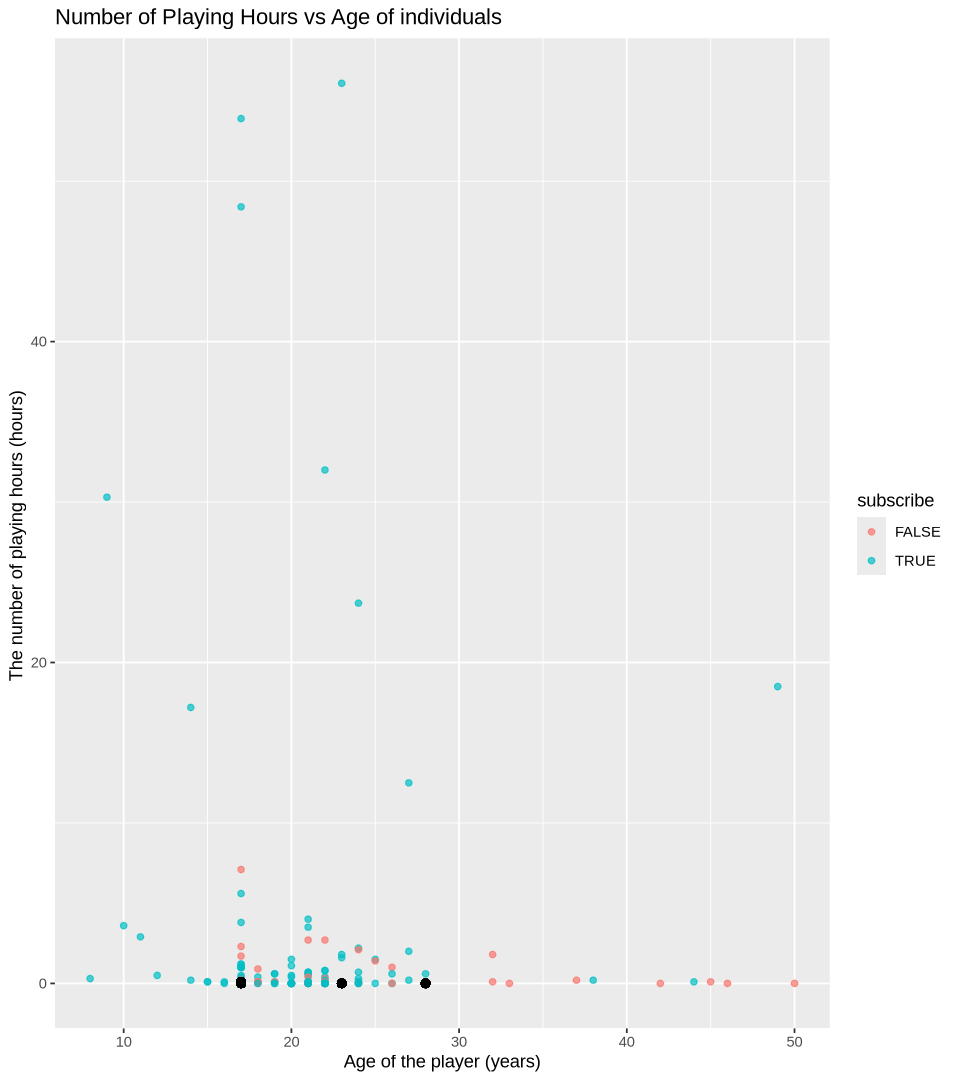

In [31]:
not_matching_prediction_plot <- hours_to_age_plot +
                                geom_point(aes(x = 17, y = 0.0), color = "black", size = 2) +
                                geom_point(aes(x = 17, y = 0.1), color = "black", size = 2) +
                                geom_point(aes(x = 28, y = 0.0), color = "black", size = 2) +
                                geom_point(aes(x = 23, y = 0.0), color = "black", size = 2) 

not_matching_prediction_plot 

The graph exhibits four points where the KNN model prediction failed to correctly predict subscription status on top of the scatter plot of played hours versus age. The plot illustrates a particular cluster of age and played hour values where determining subscriptions based on nearby data points is inaccurate and unreliable. This could be due to overlapping characteristics between subscribers and non-subscribers in that region, making it difficult for the model to distinguish between the two classes. Visualizing these incorrect predictions helps us better understand the limitations of KNN algorithms, particularly in areas where the data lacks a clear separation between categories. 


## Discussion:
To investigate whether age and the number of played hours influence a player's likelihood of subscribing to a game-related Minecraft newsletter, the K-Nearest Neighbors (KNN) classification was used. The scatter plot displaying actual vs. predicted subscription status revealed four points where the KNN model failed to predict accurately, specifically in areas where players had low playing hours and were relatively young (age 16-25). The visual supports the idea that there is no strong, consistent relationship between age, playtime and subscription status in those data segments. The confusion matrix confirms this, showing 13 false positives and 4 false negatives, with an overall accuracy of about 64.6%. Initially, we expected that older individuals (aged 30+) would be less likely to subscribe due to busier lifestyles than younger individuals (aged 10-15). At the same time, players with gaming hours would be more likely to be subscribed due to deeper engagement and the desire to get the earliest updates of the game. While the scatter plot slightly supports the idea that players with higher playing time and more often subscribers, the model ultimately relieved that age and playtime hours are weak predictors. Specifically, when both the variables are low(ex. younger players with minimal playing hours), the model performs poorly in classifying subscription status. In contrast, with different conditions like younger players and higher playing hours, the model performs well at predicting subscription status. 
This outcome suggests that other variables, such as player experience and gender, could be more meaningful for future analysis. While the project aimed to explore whether age and playing hours could predict subscription status, these features alone were insufficient. Additional variables will be necessary to understand better what influences a player's likelihood to subscribe.
These findings also provide important suggestions for game developers and researchers who aim to understand player engagement better. Recognizing that age and playtime alone are not strong predictors of newsletter subscription suggests that relying on simple demographics may lead to ineffective targeting strategies. Including more specific demographics and data collection, such as player motivations, communication preferences, etc, could aid in this research study as demographics such as age and hours played can be too generalized.  Future questions that can guide further research on this topic and improve the KNN model are: What factors other than age and played hours influence a player's likelihood to subscribe to a Minecraft newsletter? 




## References:

PLAI Group. (n.d.). Programming languages for artificial intelligence. University of British Columbia. https://plai.cs.ubc.ca/
